## Let's Get to it!

In [19]:
%load_ext autoreload
%autoreload 2

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from project_5 import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import matplotlib.image as mpimg
import time
from moviepy.editor import VideoFileClip


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First we load the two sets of images just to get an idea of what we will be looking at:

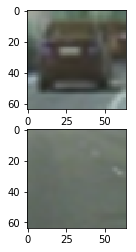

In [20]:
%autoreload 2

sample_vehicle = 'vehicles/GTI_FAR/image0000.png'
sample_non_vehicle = 'non-vehicles/GTI/image1.png'

vehicle_img = cv2.imread(sample_vehicle)
non_vehicle_img = cv2.imread(sample_non_vehicle)

plt.subplot(2,1,1)
plt.imshow(vehicle_img)
plt.subplot(2,1,2)
plt.imshow(non_vehicle_img)
plt.show()

## Next we Examine an example of the Hog Visualization of a single image.

Number of cars:
8792
Number of Non Cars:
8968


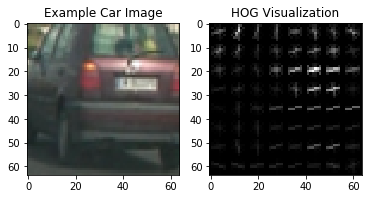

In [35]:
%autoreload 2

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog

# Read in our vehicles and non-vehicles
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')

print("Number of cars:")
print(len(cars))
print("Number of Non Cars:")
print(len(notcars))

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 11
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = project_5.get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()

## Further experimenting:

Below was used as a testing ground for the hog features. It took a few tries of playing with the values to get the right outcome so this was helpful for quick tests. This is adapted from the coursework. 

In [23]:
%autoreload 2

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [300, 700] # Min and max in y to search in slide_window()

print("Thinking")
t=time.time()
car_features = project_5.extract_features(cars, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = project_5.extract_features(notcars, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Thinking
60.49 Seconds to extract HOG features...
Using: 10 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 4248
8.38 Seconds to train SVC...
Test Accuracy of SVC =  0.9876
My SVC predicts:  [ 1.  1.  1.  0.  0.  0.  1.  0.  0.  1.]
For these 10 labels:  [ 1.  1.  1.  0.  0.  0.  1.  0.  0.  1.]
0.00283 Seconds to predict 10 labels with SVC


## Sliding Window Testing

Below is an example of what the sliding windows look like. I used this to figure out the y-vertical spacing and to see different sizes of boxes. 

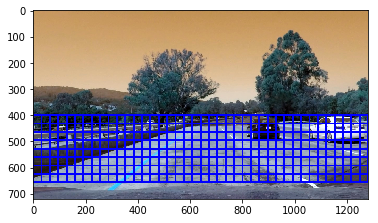

In [36]:
%autoreload 2

image = cv2.imread('test_images/test1.jpg')
windows = project_5.slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 656], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
                       
window_img = project_5.draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()

## Extract Hog Features From Data Set

Now we begin to do the actual training and parsing of the video. The first step is to extract the Hog parameters. The parameters suggested from the course work were:

* YCrCb color space
* orient of 8
* 8 pix per cell
* 2 cells per block'
* ALL hog channels. 

After some testing, I made a slight adjustment to these values to get a more consistent outcome. The changes were:

* orient of 10
* pix per cell of 16. 

Below we extract the hog features. The function for extracting the hog features is adapted from the examples in the coursework and can be found on line 67 in the project5 python file. 

In [39]:
%autoreload 2
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [300, 700] # Min and max in y to search in slide_window()

# Read in car and non-car images
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
'''
sample_size = 500
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]
'''


print('Getting Features')
t=time.time()


car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to get car features...')
t=time.time()
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to get  non car features...')
print("This stage complete")

Getting Features
31.66 Seconds to get features...
29.96 Seconds to get features...
This stage complete


## Train Classifier with Hog Features

Below we use the hog features gathered in the previous code block to train the SVC classifier. This is built off of the code supplied in the lectures. The features are scaled you a standard scaler. For the Linear SVC we use the following parameters:

* C = 0.05
* penalty = l2 (default)
* loss = hinge

From this stack overflow post:http://stats.stackexchange.com/questions/31066/what-is-the-influence-of-c-in-svms-with-linear-kernel

It looks like the smaller C value helps maximise the distance between the two datasets at the expense of allowing some outliers to fall into the other data set. This worked much better than larger values of C. I didn't notice a huge difference between hinge and square_hinge, hinge was chosen as I would occasionally notice a few tenths of a percent better outcome when using it. 

In [58]:
%autoreload 2

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(C=0.05, penalty='l2', loss='hinge')

# Check the training time for the SVC
t=time.time()

svc.fit(X_train, y_train)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


Using: 10 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 4248
4.26 Seconds to train SVC...
Test Accuracy of SVC =  0.9887


## Sliding Window

Sliding window searching allowed us to identify "Hot Windows" where the features of interest would be located. Initially I had planned on starting with a general sweep of the whole area at one size, and then going back and creating a new version with multiple sized windows at different vertical locations. This technique was described at the end of the lesson. However, after implementing it I saw a worse ability to parse the squares of interest than before so I stuck to a single size. Below we scan with an overlap of 75%. In the actual pipeline we use a slightly different technique that finds the hog features of the whole dataset first and then scans at a scale of 1.5. The slide window function is on line 133, the search window function is on line 224, and the find function (one used in real pipeline) is on line 399. An example of the output is below this code block for the first two functions, and an example output of the faster "find" function is a few blocks down. 


[((576, 372), (672, 468)), ((816, 372), (912, 468)), ((840, 372), (936, 468)), ((1128, 372), (1224, 468)), ((456, 396), (552, 492)), ((792, 396), (888, 492)), ((816, 396), (912, 492)), ((840, 396), (936, 492)), ((864, 396), (960, 492)), ((1032, 396), (1128, 492)), ((1056, 396), (1152, 492)), ((1080, 396), (1176, 492)), ((1104, 396), (1200, 492)), ((1128, 396), (1224, 492)), ((1152, 396), (1248, 492)), ((792, 420), (888, 516)), ((816, 420), (912, 516)), ((840, 420), (936, 516)), ((864, 420), (960, 516)), ((1056, 420), (1152, 516)), ((1080, 420), (1176, 516)), ((1104, 420), (1200, 516)), ((1128, 420), (1224, 516)), ((1152, 420), (1248, 516)), ((1176, 420), (1272, 516)), ((1176, 444), (1272, 540))]


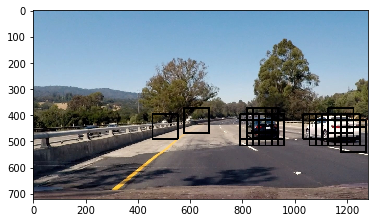

In [59]:
image = mpimg.imread('test_images/test4.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print(hot_windows)

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 0), thick=6)                    

plt.imshow(window_img)
%autoreload 2
plt.show()

In [60]:
%autoreload 2
from project_5 import *

image = mpimg.imread('test_images/test1.jpg')
#image = cv2.imread('test_images/test1.jpg')
image = image.astype(np.float32)/255
ystart = 400
ystop = 656
scale = 1.5
    
hot_windows = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
print(hot_windows)

[((816, 400), (912, 496)), ((864, 400), (960, 496)), ((1056, 400), (1152, 496)), ((1104, 400), (1200, 496))]


Below we apply the Head function to the faster "Find cars" function.

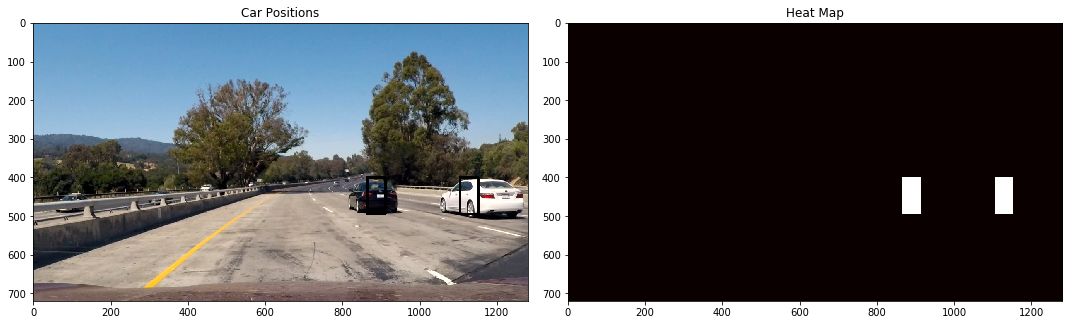

In [61]:
%autoreload 2
from project_5 import *

box_list = hot_windows


# Read in image similar to one shown above 
heat = np.zeros_like(image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize=(15, 12))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.show()

Below is the fully implemented pipeline. This method is prone to false positive and occasionally briefly losing the images. To fix this, we implement a buffer similar to project 4. The buffer is in its own class on line 351. Essentially we hold the last 25 frames of video and sum them together. If the heat map exceeds a threshold (15) we consider it a success. These values took a bit of tuning. Too high of a buffer and there would be no false positives but the heatmaps would get much larger than they need to be as they were tracking very old values of cars locations. Two low of a threshold and we would get false positives and two high of a threshold and we would lose the cars. 

In [62]:
%autoreload 2

from project_5 import *

output_file = './processed_project_video.mp4'
#input_file = './shorter_project_video.mp4'
input_file = './project_video.mp4'


clip = VideoFileClip(input_file)
vehicleFinder = VehicleFinder(svc = svc, X_scaler = X_scaler, color_space = color_space, orient = orient, 
                              pix_per_cell = pix_per_cell, cell_per_block = 2, hog_channel = hog_channel)
out_clip = clip.fl_image(vehicleFinder.find) 
out_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video ./processed_project_video.mp4
[MoviePy] Writing video ./processed_project_video.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]


  0%|          | 1/1261 [00:00<04:00,  5.23it/s]


  0%|          | 2/1261 [00:00<03:55,  5.34it/s]


  0%|          | 3/1261 [00:00<03:50,  5.46it/s]


  0%|          | 4/1261 [00:00<03:46,  5.56it/s]


  0%|          | 5/1261 [00:00<03:49,  5.47it/s]


  0%|          | 6/1261 [00:01<03:53,  5.37it/s]


  1%|          | 7/1261 [00:01<03:57,  5.29it/s]


  1%|          | 8/1261 [00:01<04:07,  5.06it/s]


  1%|          | 9/1261 [00:01<04:23,  4.76it/s]


  1%|          | 10/1261 [00:01<04:26,  4.70it/s]


  1%|          | 11/1261 [00:02<04:34,  4.55it/s]


  1%|          | 12/1261 [00:02<04:40,  4.45it/s]


  1%|          | 13/1261 [00:02<04:46,  4.36it/s]


  1%|          | 14/1261 [00:02<04:52,  4.26it/s]


  1%|          | 15/1261 [00:03<05:04,  4.09it/s]


  1%|▏         | 16/1261 [00:03<05:08,  4.04it/s]


  1%|▏         | 17/1261 [00:03<05:14,  3.95it/s]


  1%|▏         | 18/1261 [00:03<05:20,  3.88it/s]


  2%|▏         | 19/1261 [0

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./processed_project_video.mp4 



## Discussion

I certainly learned a lot in this project. SVMs were fairly straight forward to implement, but took much more time to implement properly. I saw in the end of the rubric it suggests trying to make the pipeline work in near real time. Currently it takes about 5-6 times as long as the video to process so I am far from meeting that goal. I would love to be able to learn more and understand how to make it meet that time constraint. I also don't know how robust the procedure is. I think this could easily break on two cars in two different lanes as different distances. If one car was say 3 feet from your car and the other was 10, but the angle of perception put them close together, then the box would probably be drawn around both giving the indication that there were two cars in front of yours at the closer distance. This could be dangerous if the car needed to change lanes suddenly but thought it was completely blocked in front of itself. Trying to remove all false positives while not losing the white car was also a bit of a challenge. Eventually I got a pretty close representation. The only false positives stem from cars on the other side of the road, and the buffer holding on to that image for a bit too long. I believe this only happened once. 